In [1]:
import os
from glob import glob
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.axes._axes import _log as matplotlib_axes_logger
import seaborn as sns
import hydrofunctions as hf
import folium
import earthpy as et
import numpy as np

# Handle date time conversions between pandas and matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Dealing with error thrown by one of the plots
matplotlib_axes_logger.setLevel('ERROR')
warnings.filterwarnings('ignore')


# Adjust font size and style of all plots in notebook with seaborn
sns.set(font_scale=1.5, style="whitegrid")

# We are adding this for you as there is a bug in hydrofunctions that
# Turns off plotting
%matplotlib inline

In [2]:
def create_df(site, start, end):
    # YOUR CODE HERE
    """Creates a Panadas DataFrame with data
    downloaded from NWIS using hydrofucntions.
    Renames columns containing discharge and
    qualification codes informaiton to "discharge" and
    "flag", respectively. Creates a "siteName", "latitude",
    and "longitude" columns. Outputs the new dataframe.

    Parameters
    ----------
    site : str
    The stream gauge site number.

    start : str
    The start date as (YYYY-MM-DD) of time period of interest.

    end : str
    The end date as (YYYY-MM-DD) of time period of interest.

    Returns
    -------
    discharge : Pandas DataFrame
    Returns a dataframe containing date discharge, qualification
    codes, site name, and latitdue and longitude data

    """
    # Response from site
    parameterCd =["00065","00060"]
    resp = hf.get_nwis(site, "dv", start, end).json()

    # Extract values to a pandas dataframe
    discharge = hf.extract_nwis_df(resp)

    # Rename columns
    discharge.columns = ["discharge", "flag"]

    # Create sitename column
    site_name = hf.get_nwis_property(resp, key="siteName")[0]

    discharge['siteName'] = site_name

    # Create lat and long column
    geoloc = hf.get_nwis_property(resp, key="geoLocation")[0]["geogLocation"]
    lat = geoloc["latitude"]
    long = geoloc["longitude"]
    discharge["latitude"] = lat
    discharge["longitude"] = long
    return discharge

In [3]:

site = ["06479215","06479438","06479500","06479525","06479770","06480000","06481000"]
start = "2018-01-01"
end = "2020-12-01"
temp_list = []

for i in site:
    df = create_df(i, start, end)
    temp_list.append(df)
    
stream_gage_df = pd.concat(temp_list)
stream_gage_df

,discharge,flag,siteName,latitude,longitude
datetime,,,,,
2018-01-01,0.04,A e,"BIG SIOUX RIVER NR FLORENCE,SD",45.180795,-97.186190
2018-01-02,0.05,A e,"BIG SIOUX RIVER NR FLORENCE,SD",45.180795,-97.186190
2018-01-03,0.05,A e,"BIG SIOUX RIVER NR FLORENCE,SD",45.180795,-97.186190
2018-01-04,0.05,A e,"BIG SIOUX RIVER NR FLORENCE,SD",45.180795,-97.186190
2018-01-05,0.04,A e,"BIG SIOUX RIVER NR FLORENCE,SD",45.180795,-97.186190
...,...,...,...,...,...
2020-11-27,NaN,P Ice,"BIG SIOUX R NEAR DELL RAPIDS,SD",43.790446,-96.745662
2020-11-28,NaN,P Ice,"BIG SIOUX R NEAR DELL RAPIDS,SD",43.790446,-96.745662
2020-11-29,NaN,P Ice,"BIG SIOUX R NEAR DELL RAPIDS,SD",43.790446,-96.745662


In [51]:
df = stream_gage_df.sort_values(by=['latitude']).reset_index()
df

,datetime,discharge,flag,siteName,latitude,longitude
0,2020-12-01,NaN,P Ice,"BIG SIOUX R NEAR DELL RAPIDS,SD",43.790446,-96.745662
1,2018-12-29,376.00,A e,"BIG SIOUX R NEAR DELL RAPIDS,SD",43.790446,-96.745662
2,2018-12-28,385.00,A e,"BIG SIOUX R NEAR DELL RAPIDS,SD",43.790446,-96.745662
3,2018-12-27,393.00,A e,"BIG SIOUX R NEAR DELL RAPIDS,SD",43.790446,-96.745662
4,2018-12-26,401.00,A e,"BIG SIOUX R NEAR DELL RAPIDS,SD",43.790446,-96.745662
...,...,...,...,...,...,...
7453,2019-12-05,17.60,P e,"BIG SIOUX RIVER NR FLORENCE,SD",45.180795,-97.186190
7454,2019-12-04,17.60,P e,"BIG SIOUX RIVER NR FLORENCE,SD",45.180795,-97.186190
7455,2019-12-03,17.70,P e,"BIG SIOUX RIVER NR FLORENCE,SD",45.180795,-97.186190
7456,2019-12-17,16.30,P e,"BIG SIOUX RIVER NR FLORENCE,SD",45.180795,-97.186190


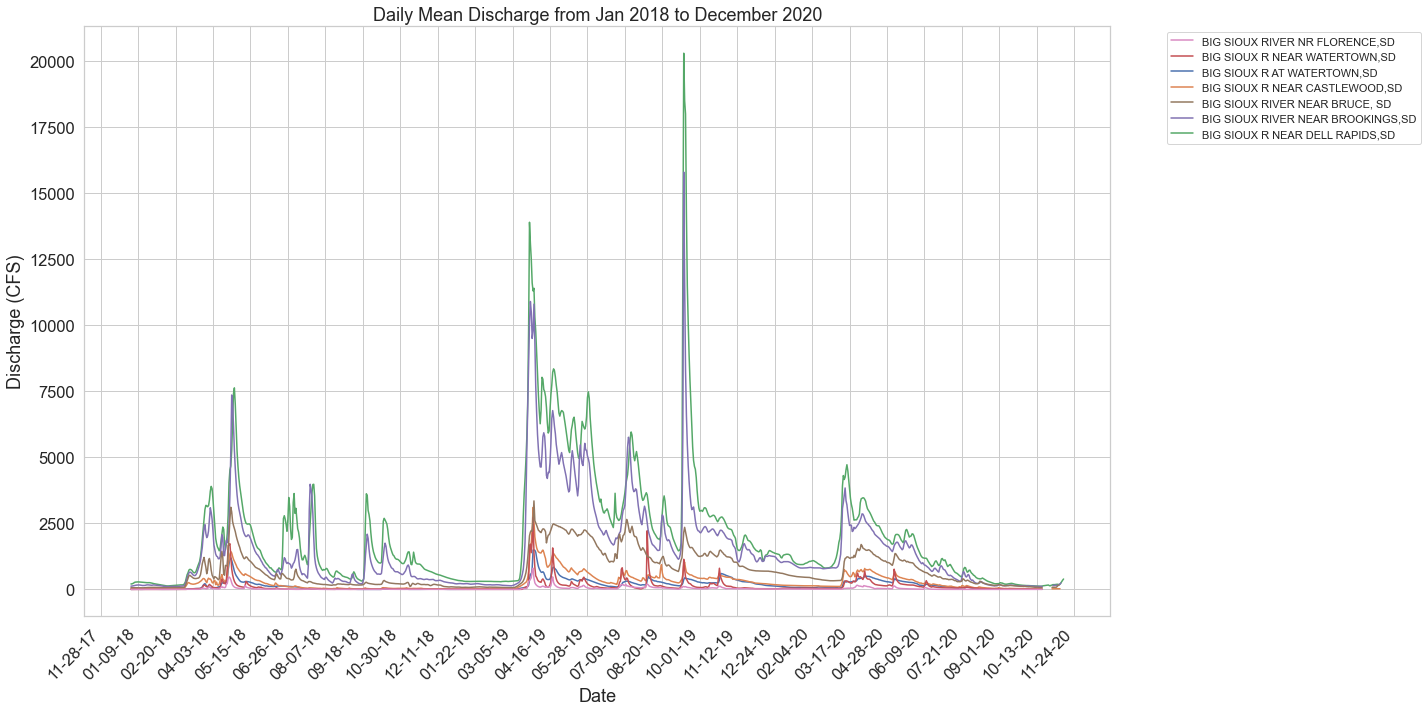

In [76]:
# Define the plot space
fig, ax = plt.subplots(figsize=(20, 10))

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

label = {"BIG SIOUX RIVER NR FLORENCE,SD": "red",
         "BIG SIOUX R NEAR WATERTOWN,SD": "green",
         "BIG SIOUX R AT WATERTOWN,SD":"blue",
         "BIG SIOUX R NEAR CASTLEWOOD,SD": "orange",
         "BIG SIOUX RIVER NEAR BRUCE, SD":"purple",
         "BIG SIOUX RIVER NEAR BROOKINGS,SD": "brown",
         "BIG SIOUX R NEAR DELL RAPIDS,SD":"black"}
# Create the plots
for i, k in df.groupby("siteName"):
    k.groupby("siteName").plot(x='datetime',
                               y='discharge',
                               label=i,
                                
                                ax=ax)
                               

# ax.xaxis.set_major_locator(years)
# ax.xaxis.set_major_formatter(years_fmt)
# ax.xaxis.set_minor_locator(months)

# ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
# ax.format_ydata = lambda x: '$%1.2f' % x  # format the price.
# ax.grid(True)
# # Define tick spacings
# month_ticks = np.arange(1, 36,1)
# year_ticks = np.arange(2018, 2020, 2)

date_form = DateFormatter("%m-%d-%y")
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=6))
plt.setp(ax.get_xticklabels(), rotation=45)

# Set up axis information for subplot 1
ax.set(xlabel="Date",
             ylabel="Discharge (CFS)",
             title="Daily Mean Discharge from Jan 2018 to December 2020",

           )
handles,labels=ax.get_legend_handles_labels()
handles,labels
handles=[handles[6],handles[3],handles[0],handles[1],handles[5],handles[4],handles[2]]
labels=[labels[6],labels[3],labels[0],labels[1],labels[5],labels[4],labels[2]]

# Position legend for subplot 2
ax.legend(handles,labels,bbox_to_anchor=(1.05, 1),
                  loc='upper left', prop={'size': 11})



plt.tight_layout()   
plt.show()

In [75]:
handles,labels=ax.get_legend_handles_labels()
handles,labels
handles=[handles[6],handles[3],handles[0],handles[1],handles[5],handles[4],handles[2]]
labels=[labels[6],labels[3],labels[0],labels[1],labels[5],labels[4],labels[2]]

([<matplotlib.lines.Line2D at 0x22768ae6910>,
 ['BIG SIOUX R AT WATERTOWN,SD',
  'BIG SIOUX R NEAR CASTLEWOOD,SD',
  'BIG SIOUX R NEAR DELL RAPIDS,SD',
  'BIG SIOUX R NEAR WATERTOWN,SD',
  'BIG SIOUX RIVER NEAR BROOKINGS,SD',
  'BIG SIOUX RIVER NEAR BRUCE, SD',
  'BIG SIOUX RIVER NR FLORENCE,SD'])

In [47]:
m = folium.Map(location=[45.108, -97.186],
               tiles='Stamen Terrain',
               zoom_start=7)

for name, xy in stream_gage_df.groupby(["siteName"]):
    folium.Marker(location=[xy.latitude[0], xy.longitude[0]],
                  popup=name,
                  icon=folium.Icon()).add_to(m)

# Display map
m

In [36]:
working_dir = os.path.join(et.io.HOME,"earth-analytics","big-sioux")
data_path = os.path.join(working_dir,"nitrate-bs-11.csv")
nitrate = pd.read_csv(data_path,
                      parse_dates=['collection_date'],
                      index_col=['collection_date'])
nitrate_df = nitrate.sort_index().reset_index()
nitrate_df

,collection_date,name,nitrate,Unnamed: 3,Unnamed: 4
0,1989-09-19,R20-89-50,NaN,NaN,NaN
1,1989-09-19,R20-89-49,0.08,NaN,NaN
2,1989-09-20,R20-89-49,NaN,NaN,NaN
3,1989-09-20,R20-89-50,0.02,NaN,NaN
4,1989-11-14,R20-89-50,0.02,NaN,NaN
...,...,...,...,...,...
123,2015-07-16,R20-89-50,0.10,NaN,NaN
124,2017-07-11,R20-89-49,0.10,NaN,NaN
125,2017-07-11,R20-89-50,0.10,NaN,NaN
126,2020-05-19,R20-89-50,0.10,NaN,NaN


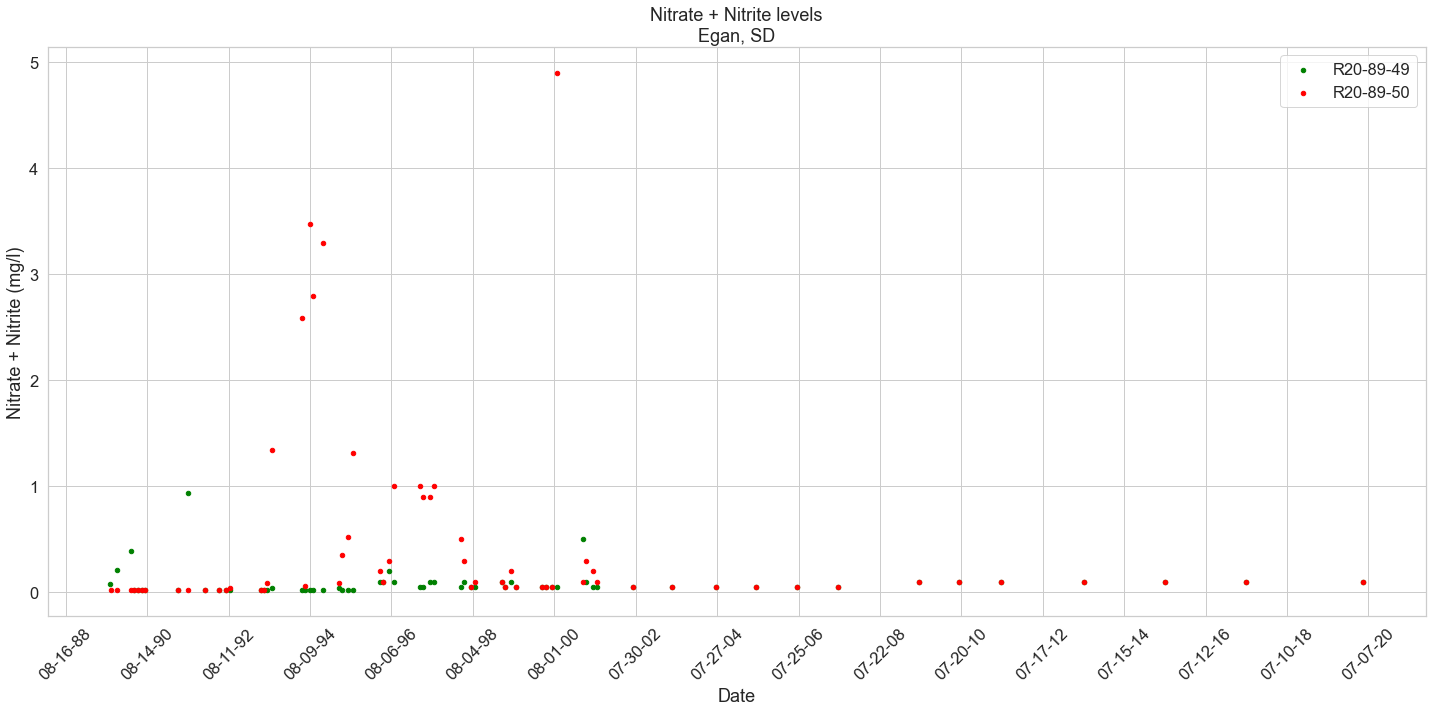

In [46]:
fig, ax1 = plt.subplots(figsize=(20,10))

labels ={"R20-89-50":"red",
         "R20-89-49":'green'}
for p, z in nitrate_df.groupby("name"):
    z.groupby('name').plot(x="collection_date",
                         y="nitrate",
                         label=p,
                         color=labels[p],
                         ax=ax1,
                        kind = 'scatter')
ax1.set(xlabel="Date",
       ylabel="Nitrate + Nitrite (mg/l)",
        title="Nitrate + Nitrite levels\nEgan, SD")

date_form = DateFormatter("%m-%d-%y")
ax1.xaxis.set_major_formatter(date_form)
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(interval=104))
plt.setp(ax1.get_xticklabels(), rotation=45)
plt.tight_layout()
plt.show()